# Question 5: Why do underdogs do better in the NHL than the NBA?

## Variance of Luck and Skill

The reason why underdogs do better in the NBA compared to the NHL is because NBA winning outcomes rely more on skill compared to the NHL. Or other words, there is less of a contribution of luck to success in the NBA compared to the NHL. Consider the following statistical equation:

Var(x+y)=var(x)+var(y), in which x and y are independent events

In sporting events, this equation looks like this:

Var(result)=var(skill)+var(luck)

For this initial analysis, I studied the regular season winning percentage of all teams in both sports to represent the real-life “results”. In both sports, teams play 82 games in a normal season and the top 8 teams in two conferences compete in a 4-round playoff tournament to win the championship. If the outcome of the games were determined completely by luck, a win or loss would have 50% probability. In this study, the variance is the measure of the spread of magnitude of win-loss records in the league. The variance of luck will then depend on the number of games played in a season. Since both sports play the same number of games in a regular season, the variance of luck across both sports can be defined with the same binomial distribution along with some uncertainty.

Bellow I presented the variance for each sport in recent seasons in which both sports played 82 games in a season:

In [1]:
pip install -U pandasql

Requirement already up-to-date: pandasql in c:\programdata\anaconda3\lib\site-packages (0.7.3)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install and import packages:
import pandas as pd
import numpy as np
from pandasql import sqldf
pyqldf = lambda q: sqldf(q, globals())
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Note: All but one dataset in this notebook was downloaded from kaggle.com's publically available data
# The dataframe not created from kaggle.com's data was scraped using pandas.

# Import relevent data for analysis:
# NBA game data from 2000-2018:
nba_data=pd.read_csv("data/nba_team_stats_00_to_18.csv")
nba_data = nba_data.rename(columns={'WIN%': 'WIN_P'})
nba_data['WIN_P']*=100
# NHL game,team data from 2000-2020:
nhl_game=pd.read_csv("data/game.csv")
nhl_team=pd.read_csv("data/team_info.csv")
nhl_team_stats=pd.read_csv("data/game_teams_stats.csv")
nhl_team_stats['won'] = nhl_team_stats['won'].map({True: 1, False: 0})

In [4]:
# Conditions for analysis:
# Only look at nba and nhl seasons with 82 games
# NHL:remove 2004-05 and 2012-13 due to lockout
# NBA:remove 2011-12 due to lockout
# NBA and NHL: remove any seasons that arnt present in both datasets

In [5]:
# 1 NBA:
# This query shows the winning record for all teams in the seasons selected
q_nba = """SELECT TEAM AS Team,
SEASON AS Year,
WIN_P AS Win_Percentage
FROM nba_data
WHERE SEASON <>'2004-05'
AND SEASON <>'2011-12'
AND SEASON <>'2012-13'
AND SEASON <>'2018-19'
GROUP BY Team,Year
ORDER BY Year
;"""
sql_nba= pyqldf(q_nba)
sql_nba.head()

,Team,Year,Win_Percentage
0,Atlanta Hawks,2000-01,30.5
1,Boston Celtics,2000-01,43.9
2,Charlotte Hornets,2000-01,56.1
3,Chicago Bulls,2000-01,18.3
4,Cleveland Cavaliers,2000-01,36.6


In [6]:
# Group by year and calculate variance for each year:
nba_variance= sql_nba.groupby(['Year']).var().reset_index().rename(columns={'Win_Percentage': 'Variance'})
nba_variance

,Year,Variance
0,2000-01,246.989631
1,2001-02,190.458571
2,2002-03,207.942857
3,2003-04,185.194951
4,2005-06,185.844828
5,2006-07,174.982402
6,2007-08,284.778954
7,2008-09,296.280931
8,2009-10,265.553437
9,2010-11,258.124138


In [7]:
# 2 NHL:
# Join 3 datasets above to get desired data
# This query shows the outcome of every game for all teams in the seasons selected
q_combined_nhl = """
    SELECT t.teamName as Team,
    g.season AS Year,
    s.won AS Won
    
    FROM nhl_team_stats AS s
    JOIN nhl_team AS t
    ON s.team_id=t.team_id
    
    JOIN nhl_game AS g  
    ON g.game_id = s.game_id
    
    WHERE g.type='R'
    AND g.season <>20042005
    AND g.season <>20112012
    AND g.season <>20122013
    AND g.season <>20182019
    AND g.season <>20192020
    AND g.season <>20202021  
;"""
sql_nhl_combined= pyqldf(q_combined_nhl)
sql_nhl_combined.head()

,Team,Year,Won
0,Flyers,20162017,0
1,Blackhawks,20162017,1
2,Sabres,20172018,0
3,Ducks,20172018,1
4,Avalanche,20152016,1


In [8]:
# Sum the number of wins by team and year:
q_nhl_wins = """
SELECT Team,
Year,
CAST (SUM(WON) AS REAL) AS Wins
FROM sql_nhl_combined
GROUP BY Team,Year
ORDER BY Year
;"""
sql_nhl= pyqldf(q_nhl_wins)
sql_nhl.head()

,Team,Year,Wins
0,Avalanche,20002001,52.0
1,Blackhawks,20002001,29.0
2,Blue Jackets,20002001,28.0
3,Blues,20002001,43.0
4,Bruins,20002001,36.0


In [9]:
# Get winning record as a percentage for the season (82 games):
sql_nhl['Wins'] = sql_nhl['Wins'].div(82)
sql_nhl['Wins']*=100

In [10]:
# Group by year and calculate variance for each year:
nhl_variance=sql_nhl.groupby(['Year']).var().reset_index().rename(columns={'Wins': 'Variance'})
nhl_variance['Year'] = nhl_variance['Year'].astype(str)
nhl_variance['Year'] = nhl_variance['Year'].str.replace('20', '-', 4).str.replace('-', '20', 1)
nhl_variance

,Year,Variance
0,2000-01,122.970044
1,2001-02,91.128365
2,2002-03,94.328431
3,2003-04,99.831108
4,2005-06,119.387064
5,2006-07,104.617531
6,2007-08,43.385505
7,2008-09,76.719522
8,2009-10,72.616874
9,2010-11,71.591212


In [11]:
# Combine nba and nhl variances for each year into one dataframe:
q_nba_nhl = """
SELECT nba.Year,
nba.Variance AS nba_variance,
nhl.Variance AS nhl_variance
FROM nba_variance AS nba
JOIN nhl_variance AS nhl
ON nba.Year=nhl.Year
;"""
sql_nba_nhl= pyqldf(q_nba_nhl)
sql_nba_nhl

,Year,nba_variance,nhl_variance
0,2000-01,246.989631,122.970044
1,2001-02,190.458571,91.128365
2,2002-03,207.942857,94.328431
3,2003-04,185.194951,99.831108
4,2005-06,185.844828,119.387064
5,2006-07,174.982402,104.617531
6,2007-08,284.778954,43.385505
7,2008-09,296.280931,76.719522
8,2009-10,265.553437,72.616874
9,2010-11,258.124138,71.591212


In [12]:
# Install visualization packages:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

In [13]:
# Configure visualization:
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 14,8

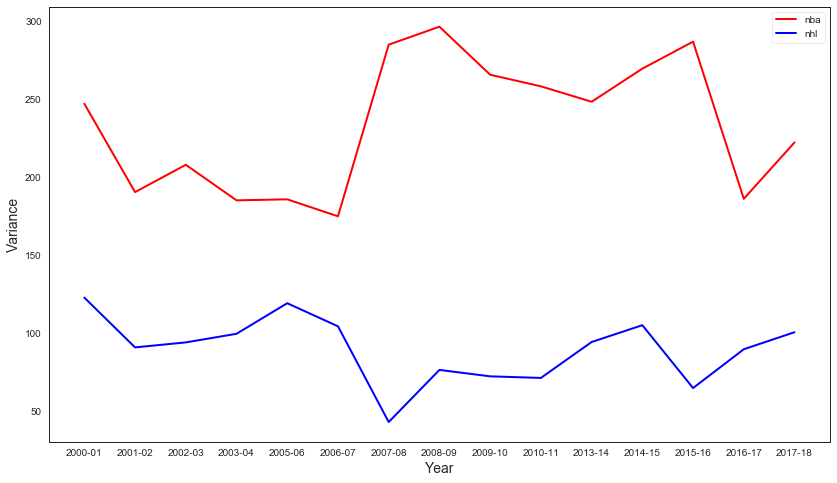

In [14]:
# Plot NBA and NHL variance:
plt.plot('Year', 'nba_variance', data=sql_nba_nhl, marker='', color='red', linewidth=2,label="nba")
plt.plot('Year', 'nhl_variance', data=sql_nba_nhl, marker='', color='blue', linewidth=2,label="nhl")
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Variance', fontsize = 14)
plt.legend()
plt.show()

As shown, the variance of all teams’ winning percentage is greater in the NBA for every season studied. The average variance for all seasons studied is shown below:

In [15]:
# Average variance throughout seasons examined:
nba_var_mean=round(sql_nba_nhl['nba_variance'].mean(),3)
nhl_var_mean=round(sql_nba_nhl['nhl_variance'].mean(),3)
print(f'The nba average variance is: {nba_var_mean}')
print(f'The nhl average variance is: {nhl_var_mean}')      

The nba average variance is: 233.931
The nhl average variance is: 90.159


The var(skill) can be calculated by the following: 

Var(skill)= var(result)- var(luck)

With the var(luck) defined by the same binomial distribution and a standard deviation in both sports, a greater var(result) equates to a the greater var(skill). A greater variance of skill means a win is more a result of skill rather than luck. This is demonstrated bellow with a binomial distribution tool simulating wins determined by 50% probability:

In [16]:
# Create luck variance function:
def var_luck(league,result_var_mean):
    from statistics import mean
    n, p = 82, 0.5  # Number of games played, probability of wining or lossing in a all luck world (50%)
    var_list=[]
    std_list=[]
    
    # 15 nba and nhl seasons were studied, so repeat this simulation 15 times:
    for i in range(0,15):
        # This represents the number of wins out out 82 games if the win is decided by a coin toss,
        # For 30 seperate tests, 1 test per team for each team, 30 teams in the league during the seasons studied
        
        number_of_wins_season= np.random.binomial(n, p, 30)
        # Calculate the win% and compute the variance and standard deviation:
        var=((number_of_wins_season/82)*100).var()
        std=((number_of_wins_season/82)*100).std()
        var_list.append(var)
        std_list.append(std)
    # After appending variance for all 15 seasons, compute the average:
    average_luck_var=mean(var_list)
    average_luck_std=mean(std_list)
    print(f'The average {league} luck variance is {round(average_luck_var,2)} with a standard deviation of {round(average_luck_std,2)}')
    print(f'Therefore the average contribution of luck over these seasons is {round((average_luck_var/result_var_mean)*100,2)}%\n')

In [17]:
# Call luck function for NBA and NHL:
var_luck('nba',nba_var_mean)
var_luck('nhl',nhl_var_mean)

The average nba luck variance is 29.87 with a standard deviation of 5.44
Therefore the average contribution of luck over these seasons is 12.77%

The average nhl luck variance is 28.63 with a standard deviation of 5.32
Therefore the average contribution of luck over these seasons is 31.75%



As shown, the average contribution of luck in the NBA is less than that of the NHL. Of course in any sport, teams want their success to involve as little luck as possible to repeat these results. A wider variance in winning record data also shows that there is a wider distribution of wins in the NBA compared to the NHL.

## Player Mintues

To support this claim that skill is more important to success in the NBA, I looked at the individual star players to showcase the underlying differences in the nature of the sports themselves. Teams want to play their most skilled players as much possible in hockey, basketball, or any sport. However, because of the underlying gameplay speed in both sports, there is a noticeable difference in the skilled players minutes per game across the NBA and NHL. The NHL is a much faster paced game than the NBA, forcing star players to rest more frequently. Bellow I looked at the top 5 players by the average percentage of the total minutes of a game they played throughout the 2014-2015 season in both sports:

In [18]:
# Import relevent data for analysis:

# NBA player minutes in the 2014-2015 season:
nba_player_min=pd.read_csv("data/nba_players_stats.csv")
nba_player_min = nba_player_min.rename(columns={'Games Played': 'Games_Played'})
# Nhl player minutes in multiple seasons:
nhl_player_min=pd.read_csv("data/nhl_player_data.csv",engine='python')

In [19]:
# 1 NBA:
# This query takes the average mintues each player played in a season and calculates that percentage of a game 
# Presents the top 5 percentages
# There are 48 mintues in a nba game
# Looking at players that played more than 75% of the season (62 games)

q_nba_min = """SELECT Name AS Athlete,
CAST((CAST((MIN/Games_Played)AS FLOAT)/48)*100 AS INT) AS Average_percent_of_game_played
FROM nba_player_min
WHERE Games_Played>62
ORDER BY Average_percent_of_game_played DESC
LIMIT 5
;"""
sql_nba_min= pyqldf(q_nba_min)
sql_nba_min

,Athlete,Average_percent_of_game_played
0,Jimmy Butler,79
1,Andrew Wiggins,75
2,Anthony Davis,75
3,James Harden,75
4,Kyrie Irving,75


In [20]:
#2 NBA:
# This query takes the average mintues each player played in a season and calculates that percentage of a game 
# Presents the top 5 percentages
#There are 60 mintues in an nhl game
#Looking at players that played more than 75% of the season (62 games) in the 2014-2015 season

q_nhl_min = """SELECT Player AS Athlete,
CAST((CAST((TOI/GP)AS FLOAT)/60)*100 AS INT) AS Average_percent_of_game_played
FROM nhl_player_min
WHERE GP>62
AND Season=2014
ORDER BY Average_percent_of_game_played DESC
LIMIT 5
;"""
sql_nhl_min= pyqldf(q_nhl_min)
sql_nhl_min

,Athlete,Average_percent_of_game_played
0,Ryan Suter\suterry01,48
1,Erik Karlsson\karlser01,45
2,Shea Weber\webersh01,43
3,Roman Josi\josiro01,43
4,Brian Campbell\campbbr02,43


As shown, NBA players logged greater floor time that season (80%) compared to players in the NHL (50%). As such, these skilled players in the NBA have greater opportunities to affect the outcome of the game. In an ideal world, Lebron James would play the entire game and Wayne Gretzky would never leave the ice.

## Player Salary and Salary Cap

Now that we’ve looked at the impact of skill on both a team and player level in both sports, we can see there is also a difference in the way the leagues are structured in building roasters. In all sports, the most skilled players are paid the highest salary. Of course this isn’t always true on a rolling basis as salaries are locked into contracts that extend multiple seasons and the current skilled player could change throughout seasons, but intuitively one can presume value is defined by performance/skill.

### Top 2 Salaries Over Multiple Seasons

It is important to first understand what a salary cap means in both sports. The salary cap is the total amount that teams may pay for players. The amount set as the salary cap each year depends on the league’s revenue for the previous season. A league’s salary cap is the same for all teams each year.

Bellow are the top 2 salaries throughout multiple years in the NBA and NHL:

In [21]:
# Conditions for analysis:
# Only look at nba and nhl seasons with 82 games
# NHL:remove 2004-05 and 2012-13 due to lockout
# NBA:remove 2011-12 due to lockout
# NBA and NHL: remove any seasons that arnt present in both datasets

In [22]:
# Import relevent data for analysis:

# NBA player salaries from 2002-2017:
nba_player_sal=pd.read_csv("data/NBASalaryData03-17.csv")

In [23]:
# 1 NBA:
# This query shows the top 2 salaries in the seasons examined:
q_nba_sal_max = """SELECT Player AS Athlete,
team AS Team,
salary AS Salary,
season AS Year
FROM nba_player_sal
WHERE season<>'2002-2003'
AND season<>'2004-2005'
AND season<>'2011-2012'
AND season<>'2012-2013'
GROUP BY season
ORDER BY salary DESC
LIMIT 2
;"""
sql_nba_sal_max= pyqldf(q_nba_sal_max)
sql_nba_sal_max

,Athlete,Team,Salary,Year
0,Stephen Curry,Golden State Warriors,37457154.0,2017-2018
1,LeBron James,Cleveland Cavaliers,30963450.0,2016-2017


In [24]:
# Create a function to calculate a player's salary percentage of the salary cap that season:

def sal_analysis_1(league,number,player_sal,cap):
    percent_of_cap=player_sal/cap
    print(f'{number}st highest player salary percentage of the salary cap in the {league}: {round(percent_of_cap*100,1)}%')
    return

# Call function and print results for highest paid player:
sal_analysis_1('NBA',1,sql_nba_sal_max['Salary'][0],99093000) # Cap from https://basketball.realgm.com/nba/info/salary_cap 

# Call function and print results for second highest paid player:
sal_analysis_1('NBA',2,sql_nba_sal_max['Salary'][1],94143000) #cap from https://basketball.realgm.com/nba/info/salary_cap  

1st highest player salary percentage of the salary cap in the NBA: 37.8%
2st highest player salary percentage of the salary cap in the NBA: 32.9%


In [25]:
# 2 NHL:

# Looking for nhl salaries in the same seasons studied in the NBA:
# Obtain the top 3 salaries (we look at 3 not 2 because the same player happened to be the was highest in two seasons)

# Web scrape hockeyzoneplus.com for data
# This website provides the top 25 salaries from seasons 2003 to 2017:
start_year = 2003
url_link = 'https://www.hockeyzoneplus.com/top-25/top-25-{}-{}'
df_list=[]
# Look through urls and pull data:
for i in range(3,18):  
      url = url_link.format(start_year,start_year+1)
      start_year=start_year+1
      if (start_year!=2005): #Remove the lockout season 2004-2005 
        df_i=pd.read_html(url,header=1)[0]
        df_i["Year"] = f'{start_year-1}-{start_year}' # Create new column in dataset to identify the year
        df_list.append(df_i) # Append newly created dataframe to a list

# Combine all dataframes into one:
nhl_player_sal = pd.concat(df_list,sort=False,ignore_index=True)
# Select relevent data:
nhl_player_sal = nhl_player_sal.loc[:, nhl_player_sal.columns.isin(['Player','NHL Salary ($US)','Year'])]
nhl_player_sal.head()

,Player,NHL Salary ($US),Year
0,Jaromir Jagr,"$11,000,000",2003-2004
1,Peter Forsberg,"$11,000,000",2003-2004
2,Keith Tkachuk,"$10,000,000",2003-2004
3,Nicklas Lidstrom,"$10,000,000",2003-2004
4,Pavel Bure,"$10,000,000",2003-2004


In [26]:
# Convert currencies into float to sort and present three highest paid players:
nhl_player_sal['NHL Salary ($US)'] = nhl_player_sal['NHL Salary ($US)'].astype(str)
nhl_player_sal['NHL Salary ($US)'] = nhl_player_sal['NHL Salary ($US)'].str.replace(',','').str.replace('$', '').astype(float)
nhl_player_sal.sort_values(by=['NHL Salary ($US)'],ascending=False).head(3)

,Player,NHL Salary ($US),Year
308,Shea Weber,14000000.0,2015-2016
253,Shea Weber,14000000.0,2013-2014
338,Anze Kopitar,14000000.0,2016-2017


In [27]:
# Call salary analysis function previously created and print results for highest paid player:
sal_analysis_1("NHL",1,nhl_player_sal['NHL Salary ($US)'][0],71400000) # Cap from https://puckpedia.com/teams

# Call salary analysis function previously created and print results for second highest paid player:
sal_analysis_1("NHL",2,nhl_player_sal['NHL Salary ($US)'][1],73000000) # Cap from https://puckpedia.com/teams 

1st highest player salary percentage of the salary cap in the NHL: 15.4%
2st highest player salary percentage of the salary cap in the NHL: 15.1%


For both the first and second highest salaries, NBA teams are paying 33% and 38% of their salary cap, while NHL team are only paying 15%. 

### Top 2 Salaries by Team

Next, I quired the teams that paid the highest salaries in each sport to examine how the salaries of the top two players on each team compared to the salary cap:

In [28]:
# Use NBA salary data from previous analysis:

# 1 NBA:
# Calculate the nba that paid the highest salary to a player and output the season that occoured:
def max_sal_team_season(team,season):
    print('The nba team that paid the highest salary:',team)
    print('The corresponding nba season this salary was paid:',season)
    return
max_sal_team_season(sql_nba_sal_max['Team'][0],sql_nba_sal_max['Year'][0])

The nba team that paid the highest salary: Golden State Warriors
The corresponding nba season this salary was paid: 2017-2018


In [29]:
# Query the salary dataset to obtain the top 2 salaries from this team and year
# (Golden State Warriors, 2017-2018)

q_nba_sal_top2 = """SELECT Player AS Athlete,
team AS Team,
salary AS Salary,
season AS Year
FROM nba_player_sal
WHERE season<>'2002-2003'
AND season<>'2004-2005'
AND season<>'2011-2012'
AND season<>'2012-2013'
AND team='Golden State Warriors'
AND season='2017-2018'
ORDER BY salary DESC
LIMIT 2
;"""
sql_nba_sal_top2= pyqldf(q_nba_sal_top2)
sql_nba_sal_top2

,Athlete,Team,Salary,Year
0,Stephen Curry,Golden State Warriors,37457154.0,2017-2018
1,Klay Thompson,Golden State Warriors,17826150.0,2017-2018


In [30]:
# Create salary function that calculated the percentage of the cap spent on the team's 2 highest paid players:

def sal_analysis_2(league,player_sal,cap):
    percent_of_cap=player_sal/cap
    print(f'The percentage of the salary cap spent on the 2 highest paid players in the {league}: {round(percent_of_cap*100,1)}%')
    return

# Call salary analysis function and print results:
sal_analysis_2("NBA",sql_nba_sal_max['Salary'][0]+sql_nba_sal_max['Salary'][1],99093000) # Cap from https://basketball.realgm.com/nba/info/salary_cap   

The percentage of the salary cap spent on the 2 highest paid players in the NBA: 69.0%


In [31]:
#2 NHL:

# Needed a new dataset with the salaries of all players in a given season, not just the top 25 scrapped
# Data was taken from a train-test dataset for the 2016-17 NHL season, to match the NBA season found previously:
nhl_test=pd.read_csv("data/nhl_test.csv",engine='python')
nhl_test_sal=pd.read_csv("data/nhl_test_salaries.csv",engine='python')
nhl_train=pd.read_csv("data/nhl_train.csv",engine='python')

In [32]:
# Combined test and train data into 1 dataset to query all players salary in this season:

# Grab relevent data:
nhl_df_1= nhl_test.loc[:, nhl_test.columns.isin(['Last Name','Team'])]
nhl_df_1.insert(0,'Salary',nhl_test_sal)

nhl_df_2= nhl_train.loc[:, nhl_train.columns.isin(['Last Name','Team','Salary'])]

# Combine into 1 dataframe:
nhl_player_sal_2017 = pd.concat([nhl_df_1,nhl_df_2],sort=False,ignore_index=True)
nhl_player_sal_2017 = nhl_player_sal_2017.rename(columns={'Last Name':'Player'})
nhl_player_sal_2017.sort_values(by=['Salary'],ascending=False).head(2)

,Salary,Player,Team
14,14000000.0,Kopitar,L.A
758,13800000.0,Toews,CHI


In [33]:
# Print the nhl that paid the highest salary to a player this season:
print('The nhl team that paid the highest salary in 2017-2018:',nhl_player_sal_2017['Team'][0])

The nhl team that paid the highest salary in 2017-2018: L.A


In [34]:
# Query the salary dataset to obtain the top 2 salaries from this team
# (L.A)

q_nhl_sal_top2 = """SELECT Player AS Athlete,
Team AS Team,
Salary AS Salary
FROM nhl_player_sal_2017
WHERE team='L.A'
ORDER BY salary DESC
LIMIT 2
;"""
sql_nhl_sal_top2= pyqldf(q_nhl_sal_top2)
sql_nhl_sal_top2

,Athlete,Team,Salary
0,Kopitar,L.A,14000000.0
1,Doughty,L.A,7450000.0


In [35]:
# Call this salary function previously created
# This calculates the percentage of the cap spent on the team's 2 highest paid players:

sal_analysis_2("NHL",sql_nhl_sal_top2['Salary'][0]+sql_nhl_sal_top2['Salary'][1],73000000) # Cap from https://puckpedia.com/teams

The percentage of the salary cap spent on the 2 highest paid players in the NHL: 29.4%


The Golden State Warriors spent 70% on their top 2 most skilled players while the L.A Kings only spent 30%. Why are NBA teams are willing to do this? Because as shown these skilled players are playing a greater percentage of the game as thus have more potential to impact the results. We also know that through many seasons, skill is always more important to a team’s success in the NBA compared to the NHL. Furthermore, an NBA roster can hold 15 players while an NHL roster can hold 23. NBA teams can afford to pay more of the salary cap to a few skilled players because they have fewer roster spots to fill. 

As shown NBA skilled players play more minutes in a game, which means less skilled players play less. A top-heavy salary NHL team has less ability to distribute the remaining salary to the rest of the roster and as a result would have less skilled players playing more minutes. With less skill, you are relying on a greater contribution of luck to winning results.

## What changes could the NBA implement that might be the most effective at levelling the playing field?

1.	Reduce the number of games in both the regular season and playoffs to increase the variance of luck and thus contribution of luck. The law of large numbers states that the average of the results obtained will become closer to the expected value as the number of trials increase. As the number of games played increases, the variance of luck will decrease. The structure of the NBA playoffs can be specifically targeted to achieve this effect. Currently, NBA championship teams need to win four best-of-7 rounds in which they play a new advancing playoff team each round. The NBA could either reduce the number of rounds or structure the rounds so that each team is required to win less games. The drawback of this solution is reducing the number of games will reduce the league’s revenue.

2.	Introduce minute restrictions for players to reduce the amount of time the most skilled players can play. This will mean the most skilled players will have to play similar minutes to less skilled players which would reduce the skill variance of teams throughout the league. This will incentivize teams to distribute their salary more evenly throughout their roster and prevent hoarding of skilled players. The drawback is fans want to see the best players play, so this will reduce the NBA’s quality of product.

3.	Reduce the market cap for previous winning teams to reduce teams’ ability to structure their rosters with top heavy salaries. For example, all teams that made the playoffs in a given season, could have their salary reduced for the next season proportionate to their record. Teams that didn’t make the playoffs would see the reverse effect to their salary, essentially distributing the salary cap from successful teams to non-successful. The challenge is that the market cap is defined each year, but player contracts can very in length over multiple seasons. 
